# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import logging
import os
import warnings
from datetime import timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (
    GridSearchCV,
    TimeSeriesSplit,
    cross_val_score,
    train_test_split,
)

import core.config.config_ as cconconf
import core.config.config_utils as ccocouti
import core.features as cofeatur
import helpers.hdbg as hdbg
import helpers.hpandas as hpandas
import helpers.hparquet as hparque
import helpers.hprint as hprint
import im_v2.crypto_chassis.data.client.crypto_chassis_clients as imvccdcccc
import research_amp.cc.crypto_chassis_api as raccchap
import research_amp.transform as ramptran

/app/helpers/hparquet.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
warnings.filterwarnings("ignore")

In [3]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-ae9aac72-9204-4f1a-850d-5311b3824397.json'


# Config

In [4]:
def get_cmtask1953_config() -> cconconf.Config:
    config = cconconf.Config()
    param_dict = {
        "data": {
            # Parameters for client initialization.
            "im_client_ohlcv": {
                "universe_version": "v1",
                "resample_1min": True,
                "root_dir": os.path.join(
                    # hs3.get_s3_bucket_path("ck"),
                    "s3://cryptokaizen-data",
                    "reorg",
                    "historical.manual.pq",
                ),
                "partition_mode": "by_year_month",
                "dataset": "ohlcv",
                "contract_type": "spot",
                "data_snapshot": "latest",
                "aws_profile": "ck",
            },
            "im_client_bid_ask": {
                "base_path": "s3://cryptokaizen-data/reorg/historical.manual.pq/20220520/bid_ask/crypto_chassis/binance/currency_pair=BTC_USDT/year=2022/",
                "aws_profile": "ck",
                "resample_bid_ask": "1T",
            },
            # Parameters for data query.
            "read_data": {
                "full_symbols": ["binance::BTC_USDT"],
                "start_ts": pd.Timestamp("2022-01-01 00:00", tz="UTC"),
                "end_ts": pd.Timestamp("2022-03-31 23:59", tz="UTC"),
                "columns": ["close", "full_symbol", "volume"],
                "filter_data_mode": "assert",
            },
        },
        "model": {
            "resampling_rule": "5T",
            "target_value": "volume",
            "delay_lag": 1,
            "num_lags": 4,
            "test_size": 0.2,
            "shuffle": False,
            "n_splits": 5,
        },
    }
    config = cconfig.Config.from_dict(param_dict)
    return config


config = get_cmtask1953_config()
print(config)

data:
  im_client_ohlcv:
    universe_version: v1
    resample_1min: True
    root_dir: s3://cryptokaizen-data/reorg/historical.manual.pq
    partition_mode: by_year_month
    data_snapshot: latest
    aws_profile: ck
  im_client_bid_ask:
    base_path: s3://cryptokaizen-data/reorg/historical.manual.pq/20220520/bid_ask/crypto_chassis/binance/currency_pair=BTC_USDT/year=2022/
    aws_profile: ck
    resample_bid_ask: 1T
  read_data:
    full_symbols: ['binance::BTC_USDT']
    start_ts: 2022-01-01 00:00:00+00:00
    end_ts: 2022-03-31 23:59:00+00:00
    columns: ['close', 'full_symbol', 'volume']
    filter_data_mode: assert
model:
  resampling_rule: 5T
  target_value: volume
  delay_lag: 1
  num_lags: 4
  test_size: 0.2
  shuffle: False
  n_splits: 5


# Read data

## OHLCV

In [5]:
# Initiate the client.
client = imvccdcccc.CryptoChassisHistoricalPqByTileClient(
    **config["data"]["im_client_ohlcv"]
)
# Load OHLCV data.
df_ohlcv = client.read_data(**config["data"]["read_data"])
# Resample.
df_ohlcv.head(3)

,full_symbol,close,volume
timestamp,,,
2022-01-01 00:00:00+00:00,binance::BTC_USDT,46250.00,40.57574
2022-01-01 00:01:00+00:00,binance::BTC_USDT,46312.76,42.38106
2022-01-01 00:02:00+00:00,binance::BTC_USDT,46368.73,51.29955


## Bid ask data

In [6]:
def resample_and_process_bid_ask_data(df, resample_rule):
    # Resample.
    df = raccchap.resample_bid_ask(df, resample_rule)
    # Convert.
    for cols in df.columns[:-1]:
        df[cols] = pd.to_numeric(df[cols], downcast="float")
    # Compute bid ask stats.
    df = ramptran.calculate_bid_ask_statistics(df)
    # Choose only necessary values (`full_symbol`).
    df = df.swaplevel(axis=1)[
        str(config["data"]["read_data"]["full_symbols"])[2:-2]
    ][["bid_size", "ask_size", "bid_price", "ask_price", "mid", "quoted_spread"]]
    return df

In [7]:
start_date = config["data"]["read_data"]["start_ts"]
end_date = config["data"]["read_data"]["end_ts"]

# Load bid ask from s3. Note: works only for 2022 for now.
# TODO(Grisha, Dan): How to load the bid/ask data through ImClient?
result = []

for i in range(start_date.month, end_date.month + 1):
    print(i)
    tmp_df = hparque.from_parquet(
        os.path.join(
            config["data"]["im_client_bid_ask"]["base_path"],
            f"month={i}/data.parquet",
        ),
        aws_profile=config["data"]["im_client_bid_ask"]["aws_profile"],
    )
    result.append(tmp_df)
bid_ask_df = pd.concat(result)
bid_ask_df = bid_ask_df[:end_date]
# Add `full_symbol` (necessary param for `calculate_bid_ask_statistics`).
bid_ask_df["full_symbol"] = str(config["data"]["read_data"]["full_symbols"])[2:-2]
# Choose only valid cols.
bid_ask_df = bid_ask_df[
    ["bid_price", "bid_size", "ask_price", "ask_size", "full_symbol"]
]
# Resample to 1-min (to be consistent with OHLCV data).
bid_ask_df_1min = resample_and_process_bid_ask_data(
    bid_ask_df, config["data"]["im_client_bid_ask"]["resample_bid_ask"]
)

bid_ask_df_1min.head(3)

1
2
3


,bid_size,ask_size,bid_price,ask_price,mid,quoted_spread
timestamp,,,,,,
2022-01-01 00:00:00+00:00,1.08286,0.24793,46214.011719,46214.019531,46214.015625,0.007812
2022-01-01 00:01:00+00:00,0.31064,0.47658,46250.000000,46250.011719,46250.007812,0.011719
2022-01-01 00:02:00+00:00,0.99036,0.03050,46310.011719,46318.109375,46314.062500,8.097656


## Combined

In [8]:
# OHLCV + bid ask
data = pd.concat([df_ohlcv, bid_ask_df_1min], axis=1)
data.head(3)

,full_symbol,close,volume,bid_size,ask_size,bid_price,ask_price,mid,quoted_spread
timestamp,,,,,,,,,
2022-01-01 00:00:00+00:00,binance::BTC_USDT,46250.00,40.57574,1.08286,0.24793,46214.011719,46214.019531,46214.015625,0.007812
2022-01-01 00:01:00+00:00,binance::BTC_USDT,46312.76,42.38106,0.31064,0.47658,46250.000000,46250.011719,46250.007812,0.011719
2022-01-01 00:02:00+00:00,binance::BTC_USDT,46368.73,51.29955,0.99036,0.03050,46310.011719,46318.109375,46314.062500,8.097656


# Compute features


In [9]:
def get_average_intraday_value(
    df: pd.DataFrame,
    timestamp: pd.Timestamp,
    lookback_days: int,
    column_name: str,
    delay: int = 0,
    mode: str = "mean",
) -> float:
    """
    Compute a feature as the mean / median of the target variable in the same
    period of time using data in the last `lookback_days` days.

    This is useful for volume, spread, volatility.

    1) Set the period that is equal `timestamp for prediciton` - N days (lookback_days).
    2) For that period, calculate mean (or median) value for target in time during days.
    3) Choose this mean value as an estimation for target in the given timestamp.

    :param df: data that contains target value
    :param timestamp: timestamp for prediciton
    :param lookback_days: historical period for estimation, in days
    :param column_name: targeted estimation value (e.g., "quoted_spread", "volume")
    :param delay: how many minutes to substract from the lookback starting period
    :param mode: 'mean' or 'median'
    :return: value of predicted target
    """
    # Choose sample data using lookback period (with a delay).
    start_date = timestamp - timedelta(days=lookback_days, minutes=delay)
    if start_date >= df.index.min() and start_date <= df.index.max():
        sample = df.loc[start_date:timestamp].loc[timestamp.time()]
        if mode == "mean":
            value = sample[column_name].mean()
        else:
            value = sample[column_name].median()
    else:
        value = np.nan
    return value

# Assemble ml_df


In [10]:
# Specify target value.
target = config["model"]["target_value"]
# Add column with intraday time.
data["time"] = data.index.time
# Add initial target values.
ml_df = data[[target]]
ml_df.columns = [f"{target}_0"]
# Add lagged values.
delay_lag = config["model"]["delay_lag"]
num_lags = config["model"]["num_lags"]
ml_df, info = cofeatur.compute_lagged_features(
    ml_df, f"{target}_0", delay_lag, num_lags
)
# Add lookback estimator.
ml_df[f"avg_intraday_{target}"] = ml_df.index
ml_df[f"avg_intraday_{target}"] = ml_df[f"avg_intraday_{target}"].apply(
    lambda x: get_average_intraday_value(data, x, 14, target)
)
# Drop the column with `{target}_0`, since Y-var will be added later (resampled).
ml_df = ml_df.drop(columns=f"{target}_0")
ml_df

,volume_2,volume_3,volume_4,volume_5,avg_intraday_volume
timestamp,,,,,
2022-01-01 00:05:00+00:00,30.45894,51.29955,42.38106,40.57574,NaN
2022-01-01 00:06:00+00:00,20.96029,30.45894,51.29955,42.38106,NaN
2022-01-01 00:07:00+00:00,35.86682,20.96029,30.45894,51.29955,NaN
2022-01-01 00:08:00+00:00,29.31849,35.86682,20.96029,30.45894,NaN
2022-01-01 00:09:00+00:00,27.81847,29.31849,35.86682,20.96029,NaN
...,...,...,...,...,...
2022-03-31 23:55:00+00:00,106.46153,27.45584,27.94996,43.41923,26.479994
2022-03-31 23:56:00+00:00,38.34090,106.46153,27.45584,27.94996,20.250477
2022-03-31 23:57:00+00:00,33.95752,38.34090,106.46153,27.45584,36.568241


# Y pre-processing

In [11]:
def attach_resampled_y_var(
    resampled_df: pd.DataFrame, estimators_df: pd.DataFrame, target: str
) -> pd.DataFrame:
    """
    :param resampled_df: Data for Y-var with >1-min frequency
    :param estimators_df: Data for X-vars with 1-min frequency
    :param target: i.e., "spread" or "volume"
    """
    if target == "spread":
        # Choose Y-var.
        resampled_df = resampled_df[[f"quoted_{target}"]]
        # Rename Y-var.
        resampled_df = resampled_df.rename(columns={"quoted_spread": "spread_0"})
    elif target == "volume":
        # Choose Y-var.
        resampled_df = resampled_df[[f"{target}"]]
        # Rename Y-var.
        resampled_df = resampled_df.rename(columns={"volume": "volume_0"})
    else:
        raise ValueError(f"Invalid target='{target}'")
    # Attach Y-var to the computed estimators.
    yx_df = pd.merge(
        resampled_df, estimators_df, left_index=True, right_index=True
    )
    return yx_df

In [12]:
# The goal is to set Y-var with 5-min frequency and
# attach previously calculated features with 1-min frequency.
resampling_rule = config["model"]["resampling_rule"]
# Resample initial bid ask.
bid_ask_df_5min = resample_and_process_bid_ask_data(bid_ask_df, resampling_rule)
# Resample initial OHLCV.
df_ohlcv_5min = df_ohlcv.resample(resampling_rule).agg(
    {"close": "last", "volume": "sum"}
)
# Combine resampled data.
df_5min = pd.concat([df_ohlcv_5min, bid_ask_df_5min], axis=1)
# Update DataFrame with ML features (add resampled y-var).
ml_df = attach_resampled_y_var(df_5min, ml_df, target)

# Now we have Y-var that is sampled by 5-min, while X-vars are 1-mins.
ml_df.head()

,volume_0,volume_2,volume_3,volume_4,volume_5,avg_intraday_volume
timestamp,,,,,,
2022-01-01 00:05:00+00:00,123.43577,30.45894,51.29955,42.38106,40.57574,NaN
2022-01-01 00:10:00+00:00,77.54574,15.96245,27.81847,29.31849,35.86682,NaN
2022-01-01 00:15:00+00:00,101.14315,23.15078,11.62620,19.01268,10.65734,NaN
2022-01-01 00:20:00+00:00,135.32479,24.88379,11.99892,24.76988,8.40902,NaN
2022-01-01 00:25:00+00:00,83.53179,9.44557,35.61633,38.03832,26.61854,NaN


# Train / test separation


In [13]:
# Specify modelling data.
ml_df = hpandas.dropna(ml_df, report_stats=True)
display(ml_df.shape)
display(ml_df.head(3))
print(f"Set of prediciton features = {list(ml_df.columns[1:])}")

INFO  removed rows with nans: 4031 / 25919 = 15.55%


(21888, 6)

,volume_0,volume_2,volume_3,volume_4,volume_5,avg_intraday_volume
timestamp,,,,,,
2022-01-15 00:00:00+00:00,116.30611,5.01042,4.82233,13.28030,3.90642,34.664149
2022-01-15 00:05:00+00:00,101.01256,24.37564,22.57418,19.15164,27.88350,22.349086
2022-01-15 00:10:00+00:00,49.98275,39.70073,10.44870,17.31996,25.61504,18.089273


Set of prediciton features = ['volume_2', 'volume_3', 'volume_4', 'volume_5', 'avg_intraday_volume']


In [14]:
# Construct X and y.
y_var_col = f"{target}_0"
y = ml_df[[y_var_col]]
X = ml_df.drop(columns=[y_var_col])
# Split into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=config["model"]["test_size"],
    shuffle=config["model"]["shuffle"],
)

# Model set-up

In [15]:
def regression_results(y_true, y_pred, mae_only: bool = True):
    # Regression metrics
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    print("MAE: ", round(mean_absolute_error, 4))
    if not mae_only:
        explained_variance = metrics.explained_variance_score(y_true, y_pred)
        mse = metrics.mean_squared_error(y_true, y_pred)
        mean_squared_log_error = metrics.mean_squared_log_error(y_true, y_pred)
        metrics.median_absolute_error(y_true, y_pred)
        r2 = metrics.r2_score(y_true, y_pred)
        print("mean_squared_log_error: ", round(mean_squared_log_error, 4))
        print("explained_variance: ", round(explained_variance, 4))
        print("r2: ", round(r2, 4))
        print("MAE: ", round(mean_absolute_error, 4))
        print("MSE: ", round(mse, 4))
        print("RMSE: ", round(np.sqrt(mse), 4))

In [16]:
n_splits = config["model"]["n_splits"]
print(f"Number of splits: {n_splits}")

Number of splits: 5


In [17]:
# Create a set of various estimation modes.
models = []
models.append(("LR", LinearRegression()))
# models.append(("NN", MLPRegressor(solver="lbfgs")))  # neural network
# models.append(("KNN", KNeighborsRegressor()))
# models.append(
#    ("RF", RandomForestRegressor(n_estimators=10))
# )  # Ensemble method - collection of many decision trees
# models.append(("SVR", SVR(gamma="auto")))  # kernel = linear
models

[('LR', LinearRegression())]

# Learn / evaluate

In [18]:
# Evaluate each model in turn
results = []
names = []
results_stats = pd.DataFrame()
for name, model in models:
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=n_splits)

    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring="r2")
    results.append(cv_results)
    names.append(name)
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))

    results_stats.loc[name, "mean_perf"] = cv_results.mean()
    results_stats.loc[name, "std_dev_perf"] = cv_results.std()

display(results_stats.sort_values("mean_perf", ascending=False))

LR: 0.332109 (0.063132)


,mean_perf,std_dev_perf
LR,0.332109,0.063132


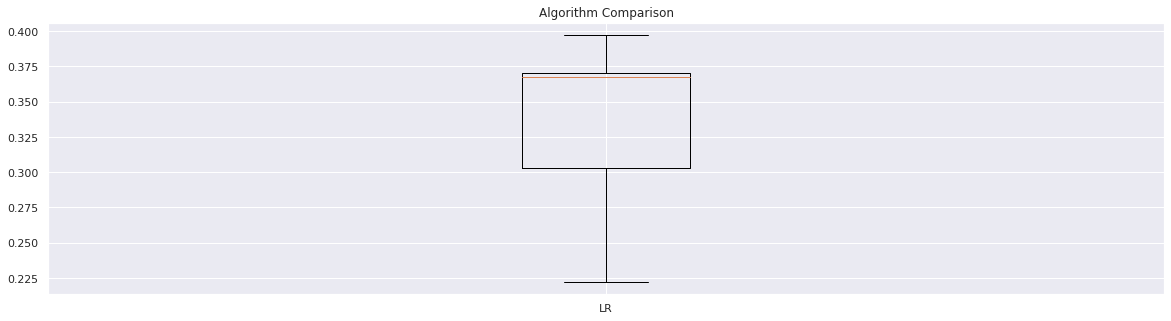

In [19]:
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title("Algorithm Comparison")
plt.show()

In [20]:
# TODO(Max): consider adding the hyperparameters tuning step.

In [21]:
# Train the model.
model = LinearRegression()
model = model.fit(X_train, y_train)

# Estimate testing results.
y_true = y_test.values
y_pred = model.predict(X_test)
regression_results(y_true, y_pred)

MAE:  76.1126


# Model analysis

In [26]:
# TODO(Max): consider displaying p-values.
# Check coefficients.
coef = pd.DataFrame(
    {"coef_value": model.coef_.ravel()},
    index=model.feature_names_in_,
)
coef = coef.sort_values(by="coef_value", ascending=False)
coef

,coef_value
avg_intraday_volume,1.878690
volume_2,1.066354
volume_5,0.607097
volume_3,0.532742
volume_4,0.456847


<AxesSubplot:xlabel='timestamp'>

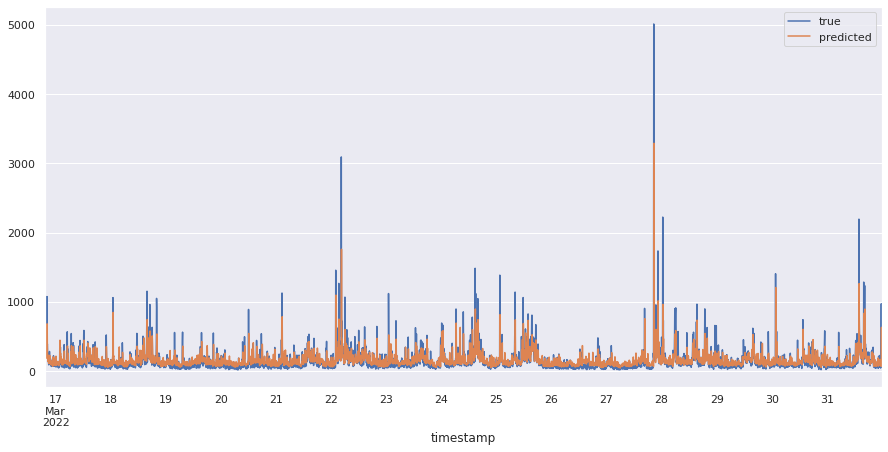

In [24]:
# Plot the results of predicting on testing sample.
lr_test = pd.concat(
    [pd.Series(y_true.ravel()), pd.Series(y_pred.ravel())], axis=1
)
lr_test.columns = ["true", "predicted"]
lr_test.index = y_test.index
lr_test.plot(figsize=(15, 7))

<AxesSubplot:xlabel='timestamp'>

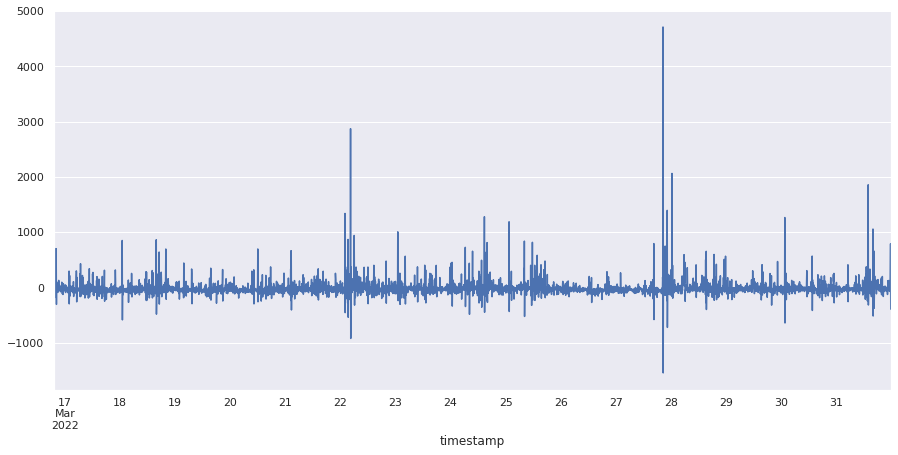

In [25]:
# Plot the difference between true and predicted values.
lr_test["diff"] = lr_test["true"] - lr_test["predicted"]
lr_test["diff"].plot(figsize=(15, 7))